In [7]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
from ieeg.auth import Session
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from iEEG_helper_functions import *

In [8]:
SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
SOZ_DIR = "../../Data/seizure_onset_zones/"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"
SEIZURE_BUFFER_TIME_MINUTES = 30  # minutes

In [9]:
# Initialize an empty list to hold the data
completed_hup_ids = [
    160,
    172,
    # 141, # not enough time before first seizure
    145,
    138,
    142,
    151,
    187,
    180,
    184,
    # 192, # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    # 165, # incomplete data
    # 169, # not enough time after the last seizure
    173,
    # 150, # not enough time before first seizure
    # 154, # incomplete data
    # 158, # incomplete data
    # 207, # not enough time before first seizure
    223,
    # 192,  ## Monday, August 21, 2023 additions this line and below # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    177,
    185,
    # 189, # not enough time before first seizure
    # 205, # not enough time before first seizure
    166,
    # 170, # not enough time before first seizure
    # 174, # not enough time before first seizure
]
# Sort completed_hup_ids in ascending order
completed_hup_ids.sort()

In [10]:
with open("dma_ieeglogin.bin", "r") as f:
    session = Session("dma", f.read())
# Initialize a dataframe with hup_id, dataset_name, fs
patients_df = pd.DataFrame(columns=["hup_id", "dataset_name", "fs"])
for patient_hup_id in completed_hup_ids:
    dataset_name = f"HUP{patient_hup_id}_phaseII"
    dataset = session.open_dataset(dataset_name)
    all_channel_labels = np.array(dataset.get_channel_labels())
    channel_labels_to_download = all_channel_labels[
        electrode_selection(all_channel_labels)
    ]

    fs = int(dataset.get_time_series_details(channel_labels_to_download[0]).sample_rate)
    # Construct a row and add it to the dataframe
    row_df = pd.DataFrame(
        [{"hup_id": patient_hup_id, "dataset_name": dataset_name, "fs": fs}]
    )
    patients_df = pd.concat([patients_df, row_df], ignore_index=True)
# Sort the dataframe by hup_id
patients_df = patients_df.sort_values(by="hup_id")
# reset the index
patients_df = patients_df.reset_index(drop=True)
patients_df

,hup_id,dataset_name,fs
0,138,HUP138_phaseII,1024
1,142,HUP142_phaseII,512
2,145,HUP145_phaseII,512
3,151,HUP151_phaseII,512
4,160,HUP160_phaseII,1024
5,166,HUP166_phaseII,1024
6,172,HUP172_phaseII,512
7,173,HUP173_phaseII,256
8,177,HUP177_phaseII,512
9,180,HUP180_phaseII,512


In [11]:
all_spikes_dfs = []
all_fs = []

In [12]:
for index, row in patients_df.iterrows():
    patient_hup_id = row["hup_id"]
    fs = row["fs"]
    all_fs.append(fs)
    print(f"Processing HUP {patient_hup_id} with fs {fs}")

    ###############################
    # Construct spike_files_df
    ###############################

    # Initialize an empty list to hold the data
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(SPIKES_OUTPUT_DIR):
        # Check if the file ends with .npy
        if filename.endswith(".npy"):
            # Use regular expression to match the pattern and extract desired numbers
            match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

            if match:
                current_patient_hup_id = int(match.group(1))
                if current_patient_hup_id != patient_hup_id:
                    continue
                interval_index = int(match.group(2))

                # Append the data to the list
                data.append(
                    {
                        "filename": filename,
                        "interval_index": interval_index,
                    }
                )

    # Convert the list of dictionaries to a pandas DataFrame
    spike_files_df = pd.DataFrame(data)
    # Sort the DataFrame by the interval index
    spike_files_df = spike_files_df.sort_values(by="interval_index")
    # Reset the index
    spike_files_df = spike_files_df.reset_index(drop=True)
    # Add a new column called "start_sample_index"
    spike_files_df["start_sample_index"] = (
        spike_files_df["interval_index"] * fs * 60 * 2
    )

    ###############################
    # Construct all_spikes_df
    ###############################
    # Initialize an empty list to store individual DataFrames
    dfs = []

    for index, row in spike_files_df.iterrows():
        filename = row["filename"]
        start_sample_index = row["start_sample_index"]

        # Load the data
        spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

        # Adjust the start_sample_index
        spike_data[:, 0] += start_sample_index

        # Convert the modified spike_data to a DataFrame and append to the dfs list
        dfs.append(
            pd.DataFrame(
                spike_data,
                columns=[
                    "peak_index",
                    "channel_index",
                    "peak",
                    "left_point",
                    "right_point",
                    "slow_end",
                    "slow_max",
                    "rise_amp",
                    "decay_amp",
                    "slow_width",
                    "slow_amp",
                    "rise_slope",
                    "decay_slope",
                    "average_amp",
                    "linelen",
                ],
            )
        )

    # Concatenate all the individual DataFrames into a single DataFrame
    all_spikes_df = pd.concat(dfs, ignore_index=True)
    # Drop any rows with any NaN values
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)
    # Make peak_index and channel_index integers
    all_spikes_df["peak_index"] = all_spikes_df["peak_index"].astype(int)
    all_spikes_df["channel_index"] = all_spikes_df["channel_index"].astype(int)

    all_spikes_df = all_spikes_df.drop(
        columns=[
            "peak",
            "left_point",
            "right_point",
            "slow_end",
            "slow_max",
            "rise_amp",
            "decay_amp",
            "slow_width",
            "slow_amp",
            "rise_slope",
            "decay_slope",
            "average_amp",
            "linelen",
        ]
    )

    ###############################
    # ISI
    ###############################
    # Calculate the inter-spike interval
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df["peak_index"].diff()

    # Drop the first row and reset index
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)

    # Convert the inter_spike_interval_samples column to integer
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df[
        "inter_spike_interval_samples"
    ].astype(int)

    all_spikes_df["inter_spike_interval_sec"] = (
        all_spikes_df["inter_spike_interval_samples"] / fs
    ).astype(int)

    all_spikes_dfs.append(all_spikes_df)

Processing HUP 138 with fs 1024
Processing HUP 142 with fs 512
Processing HUP 145 with fs 512
Processing HUP 151 with fs 512
Processing HUP 160 with fs 1024
Processing HUP 166 with fs 1024
Processing HUP 172 with fs 512
Processing HUP 173 with fs 256
Processing HUP 177 with fs 512
Processing HUP 180 with fs 512
Processing HUP 184 with fs 512
Processing HUP 185 with fs 512
Processing HUP 187 with fs 512
Processing HUP 223 with fs 1024


In [13]:
thresholds = [4.6, 4, 4.3, 4, 5.5, 4.1, 4, 3, 4, 4, 4, 3.7, 4, 5]
thresholds = np.exp(thresholds)
thresholds

array([ 99.48431564,  54.59815003,  73.6997937 ,  54.59815003,
       244.69193226,  60.3402876 ,  54.59815003,  20.08553692,
        54.59815003,  54.59815003,  54.59815003,  40.44730436,
        54.59815003, 148.4131591 ])

In [14]:
for all_spikes_df, fs, hup_id, threshold in zip(
    all_spikes_dfs, all_fs, completed_hup_ids, thresholds
):
    print(f"HUP {hup_id} with fs {fs}")
    # Convert peak_index to second
    all_spikes_df["peak_second"] = all_spikes_df["peak_index"] // fs
    # Convert peak_index to minute
    all_spikes_df["peak_minute"] = all_spikes_df["peak_index"] / fs // 60
    # Convert peak_index to hour
    all_spikes_df["peak_hour"] = all_spikes_df["peak_index"] / fs // 3600

HUP 138 with fs 1024
HUP 142 with fs 512
HUP 145 with fs 512
HUP 151 with fs 512
HUP 160 with fs 1024
HUP 166 with fs 1024
HUP 172 with fs 512
HUP 173 with fs 256
HUP 177 with fs 512
HUP 180 with fs 512
HUP 184 with fs 512
HUP 185 with fs 512
HUP 187 with fs 512
HUP 223 with fs 1024


## Percentage of channels with spikes

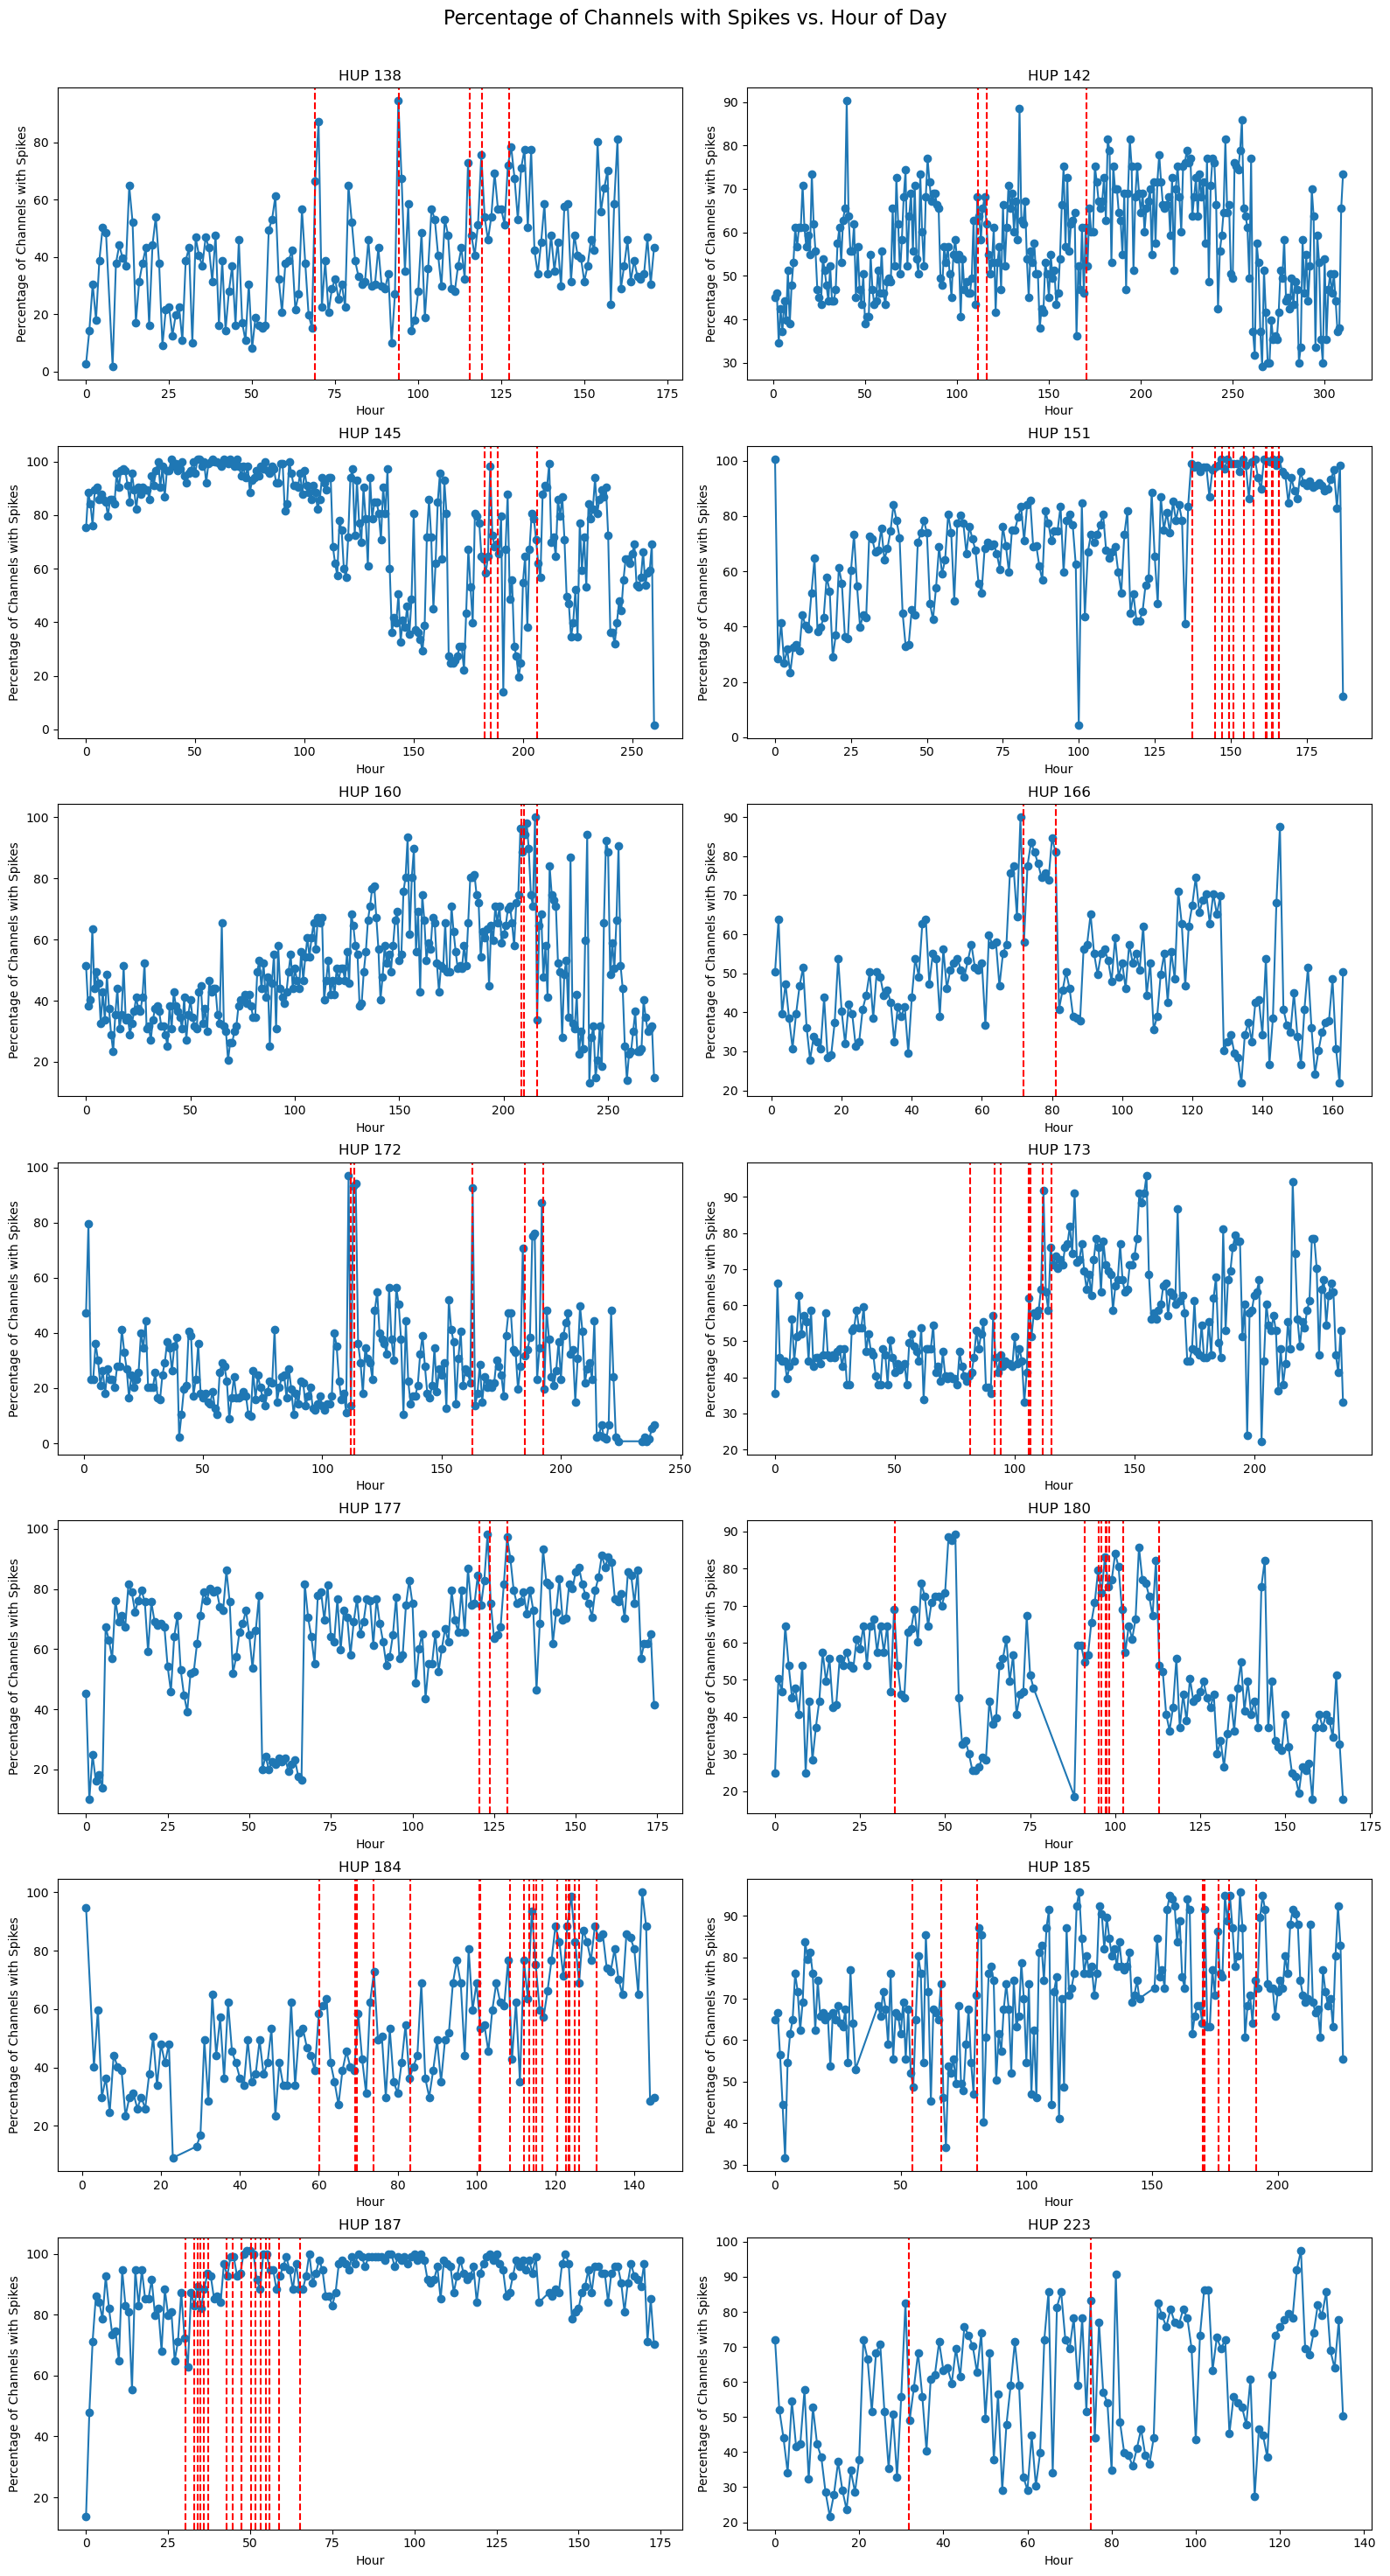

In [21]:
# Creating a subplot figure
n_patients = len(all_spikes_dfs)
fig, axarr = plt.subplots(
    nrows=(n_patients + 1) // 2, ncols=2, figsize=(16, 4 * (n_patients + 1) // 2)
)

# Looping over the dataframes
for all_spikes_df, fs, hup_id, threshold in zip(
    all_spikes_dfs, all_fs, completed_hup_ids, thresholds
):
    # Determine the total number of channels
    total_channels = all_spikes_df["channel_index"].max()

    # Load seizure times and convert to hours
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours

    # Group by peak_hour and count unique channel_index, then convert to percentage
    grouped = (
        all_spikes_df.groupby("peak_hour")["channel_index"].nunique() / total_channels
    ) * 100

    # Get the subplot index
    idx = completed_hup_ids.index(hup_id)
    row = idx // 2
    col = idx % 2

    # Plotting the percentage of channels that had a spike per hour
    axarr[row, col].plot(grouped.index, grouped.values, marker="o", linestyle="-")

    for seizure_time in seizure_times_hour:
        axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

    axarr[row, col].set_title(f"HUP {hup_id}")
    axarr[row, col].set_xlabel("Hour")
    axarr[row, col].set_ylabel("Percentage of Channels with Spikes")

# Delete unused subplots
for i in range(n_patients, 2 * ((n_patients + 1) // 2)):
    row = i // 2
    col = i % 2
    fig.delaxes(axarr[row, col])

plt.tight_layout()
# Add a title
fig.suptitle("Percentage of Channels with Spikes vs. Hour of Day", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()